Note: This code is just to explain the topic Pix2Pix gan, I did not fine tune the parameters or trained for long hours, feel free to train longer and fine tune it.

In [1]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
!tar -xzvf facades.tar.gz

--2019-03-12 21:49:54--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  4.23MB/s    in 6.2s    

2019-03-12 21:50:02 (4.63 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.jpg
facade

In [0]:
import random
import matplotlib.pyplot as plt
import os, time,itertools, imageio, pickle
import tensorflow as tf
import numpy as np

In [0]:
def lrelu(X, leak=0.3):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
b_init = tf.constant_initializer(1.0)

def generator(x, isTrain=True, reuse=False):
    
    with tf.variable_scope('generator', reuse=reuse):

        # encoder
        conv1 = lrelu(tf.layers.conv2d(x, 64, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init))
        conv2 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv1, 128, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv3 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv2, 256, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv4 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv3, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv5 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv4, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv6 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv5, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv7 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv6, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        conv8 = tf.nn.relu(tf.layers.conv2d(conv7, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init))

        # decoder and skip connections
        deconv1 = tf.nn.dropout(tf.layers.batch_normalization(tf.layers.conv2d_transpose(conv8, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain), keep_prob=0.5)
        deconv1 = tf.nn.relu(tf.concat([deconv1, conv7], 3))
        
        deconv2 = tf.nn.dropout(tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv1, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain), keep_prob=0.5)
        deconv2 = tf.nn.relu(tf.concat([deconv2, conv6], 3))
        
        deconv3 = tf.nn.dropout(tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv2, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain), keep_prob=0.5)
        deconv3 = tf.nn.relu(tf.concat([deconv3, conv5], 3))
        
        deconv4 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv3, 512, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        deconv4 = tf.nn.relu(tf.concat([deconv4, conv4], 3))
        
        deconv5 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv4, 256, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        deconv5 = tf.nn.relu(tf.concat([deconv5, conv3], 3))
        
        deconv6 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv5, 128, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        deconv6 = tf.nn.relu(tf.concat([deconv6, conv2], 3))
        
        deconv7 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(deconv6, 64, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        deconv7 = tf.nn.relu(tf.concat([deconv7, conv1], 3))
        
        deconv8 = tf.nn.tanh(tf.layers.conv2d_transpose(deconv7, 3, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init))

        return deconv8

def discriminator(x, y, isTrain=True, reuse=False):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        cat1 = tf.concat([x, y], 3)
        conv1 = lrelu(tf.layers.conv2d(cat1, 64, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init))
        conv2 = lrelu(tf.layers.batch_normalization(tf.layers.conv2d(conv1, 128, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain))
        
        conv3 = tf.layers.batch_normalization(tf.layers.conv2d(conv2, 256, [4, 4], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        conv3 = lrelu(tf.pad(conv3, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT"))
        
        conv4 = tf.layers.batch_normalization(tf.layers.conv2d(conv3, 512, [4, 4], strides=(1, 1), padding='valid', kernel_initializer=w_init, bias_initializer=b_init), training=isTrain)
        conv4 = lrelu(tf.pad(conv4, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT"))
        
        conv5 = tf.layers.conv2d(conv4, 1, [4, 4], strides=(1, 1), padding='valid', kernel_initializer=w_init, bias_initializer=b_init)
        
        out = tf.nn.sigmoid(conv5) #gives 30*30 patchGAN

        return out, conv5

In [0]:
class data_loader:
    def __init__(self, root, batch_size=1, shuffle=False):
        self.root = root
        self.batch_size = batch_size
        self.file_list = os.listdir(self.root)
        if shuffle:
            self.file_list = list(np.array(self.file_list)[random.sample(range(0, len(self.file_list)), len(self.file_list))])
        img = plt.imread(self.root + '/' + self.file_list[0])
        self.shape = (len(self.file_list), img.shape[0], img.shape[1], img.shape[2])
        self.flag = 0

    def next_batch(self):
        if self.flag + self.batch_size > self.shape[0]:
            self.file_list = list(np.array(self.file_list)[random.sample(range(0, len(self.file_list)), len(self.file_list))])
            self.flag = 0

        output = np.zeros((self.batch_size, self.shape[1], self.shape[2], self.shape[3]))
        temp = 0
        for i in range(self.flag, self.flag + self.batch_size):
            output[temp] = plt.imread(self.root + '/' + self.file_list[i])
            temp = temp + 1

        self.flag += self.batch_size

        return output

In [0]:
DATA_PATH = "facades/"
batch_size = 16

In [0]:
train = data_loader(DATA_PATH+"train", batch_size, shuffle=True)
test = data_loader(DATA_PATH + "test", batch_size, shuffle=True)

In [7]:
test_img = test.next_batch()
img_size = test_img.shape[1]
channels = 3
l1_weight = 100.0
test_img.shape

(16, 256, 512, 3)

In [0]:
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, channels))
y = tf.placeholder(tf.float32, shape=(None, img_size, img_size, channels))

In [0]:
test_x = test_img[:, :, img_size:, :]
test_y_ = test_img[:, :, 0:img_size, :]

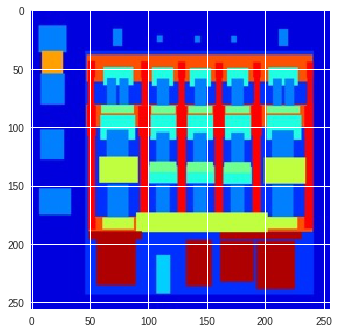

In [10]:
plt.imshow(test_x[7].astype(np.uint8))
plt.show()

In [11]:
G_x = generator(x)
D_real_outputs, D_real_logits = discriminator(x, y)
D_fake_outputs, D_fake_logits = discriminator(x, G_x, reuse=True)


D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, 
                                                                     labels=tf.ones_like(D_real_logits)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits,
                                                                     labels=tf.zeros_like(D_fake_logits)))
D_loss = (D_loss_real + D_loss_fake)

G_loss_gan = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, 
                                                                labels=tf.ones_like(D_fake_logits)))
G_l1_loss = tf.reduce_mean(tf.reduce_sum(tf.abs(G_x - y), 3))

G_loss = G_loss_gan + G_l1_loss * l1_weight


Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

D_solver = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5).minimize(D_loss, var_list=D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5).minimize(G_loss, var_list=G_vars)

Instructions for updating:
Use tf.cast instead.


In [0]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [0]:
# to show the results

def norm(img):
    return (img - 127.5) / 127.5

test_x = norm(test_x)

def show_result(num_epoch):
    
    test_images = sess.run(G_x, {x: test_x})

    size_figure_grid = 4
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(4, 4))
    
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        a = np.reshape(test_images[k], (256, 256, 3))*255
        ax[i, j].imshow(a.astype(np.uint8))

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    plt.show()

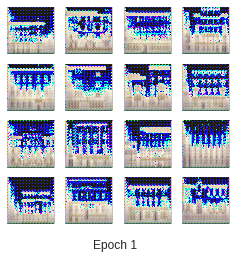

Iter: 0
D loss: 0.3862
G_loss: 114.4

The total time for epoch0 is49.39186334609985 


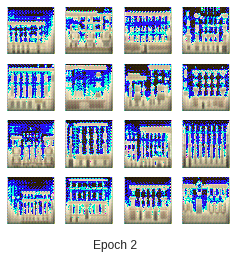

Iter: 1
D loss: 0.2811
G_loss: 96.63

The total time for epoch1 is42.821247577667236 


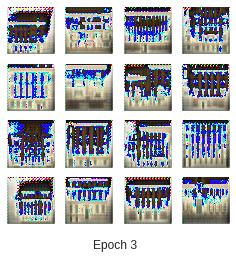

Iter: 2
D loss: 0.09142
G_loss: 99.75

The total time for epoch2 is43.06064200401306 


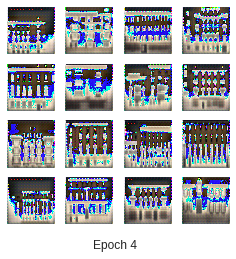

Iter: 3
D loss: 0.1435
G_loss: 104.8

The total time for epoch3 is43.08666777610779 


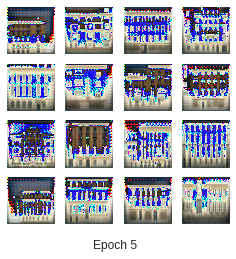

Iter: 4
D loss: 0.08961
G_loss: 113.3

The total time for epoch4 is43.321160316467285 


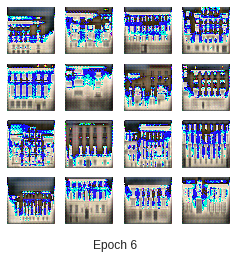

Iter: 5
D loss: 0.326
G_loss: 97.83

The total time for epoch5 is42.97102999687195 


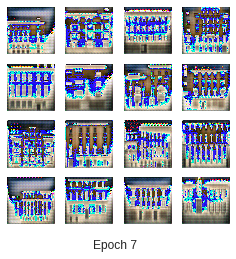

Iter: 6
D loss: 0.1173
G_loss: 96.63

The total time for epoch6 is43.05494689941406 


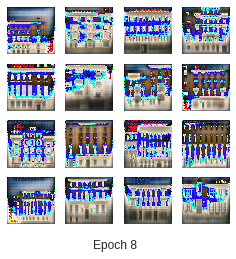

Iter: 7
D loss: 0.7163
G_loss: 99.36

The total time for epoch7 is43.229493618011475 


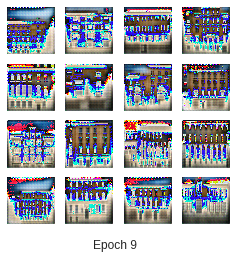

Iter: 8
D loss: 0.3303
G_loss: 107.0

The total time for epoch8 is43.040515661239624 


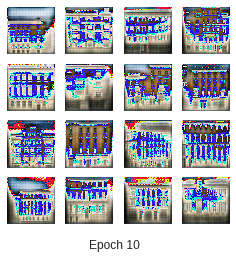

Iter: 9
D loss: 0.1005
G_loss: 95.17

The total time for epoch9 is43.05761170387268 


KeyboardInterrupt: ignored

In [15]:
for it in range(200):
    
    epoch_start_time = time.time()
        
    for iter in range(train.shape[0] // batch_size):
                
        train_data = train.next_batch()
        
        train_x = norm(train_data[:, :, img_size:, :])
        train_y = norm(train_data[:, :, 0:img_size, :])
        
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={x: train_x, y: train_y})
        
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={x: train_x, y: train_y})

    if it % 1 == 0:
        
        show_result((it + 1))
        
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print("The total time for epoch{0} is{1} ".format(it,per_epoch_ptime))